This notebook demonstrates how to predict IC50 from BindingDB data using a DeepPurpose model. There's a lot of room for tweaking things here, but the model performance with minimal code and a relatively short training time is surprisingly good.

In [6]:
import os

from DeepPurpose import utils, dataset, CompoundPred
from DeepPurpose import DTI as models
import warnings
warnings.filterwarnings("ignore")

# Data Importing

The entirety of BindingDB is saved as a .tsv file. The function `process_BindingDB` loads it into a Pandas dataframe with three columns: drugs (SMILES format), targets (protein primary structure), and binding score (in this case IC50). The `convert_to_log` flag makes it pIC50.

TODO: what are the other arguments to `process_BindingDB`?
can I save the dataframe for easier access?

In [2]:
data_path = './data//BindingDB_All.tsv'
X_drugs, X_targets, y = dataset.process_BindingDB(path = data_path, df = None, y = 'IC50', binary = False, convert_to_log = True, threshold = 0)

Loading Dataset from path...


b'Skipping line 772572: expected 193 fields, saw 205\nSkipping line 772598: expected 193 fields, saw 205\n'
b'Skipping line 805291: expected 193 fields, saw 205\n'
b'Skipping line 827961: expected 193 fields, saw 265\n'
b'Skipping line 1231688: expected 193 fields, saw 241\n'
b'Skipping line 1345591: expected 193 fields, saw 241\nSkipping line 1345592: expected 193 fields, saw 241\nSkipping line 1345593: expected 193 fields, saw 241\nSkipping line 1345594: expected 193 fields, saw 241\nSkipping line 1345595: expected 193 fields, saw 241\nSkipping line 1345596: expected 193 fields, saw 241\nSkipping line 1345597: expected 193 fields, saw 241\nSkipping line 1345598: expected 193 fields, saw 241\nSkipping line 1345599: expected 193 fields, saw 241\n'
b'Skipping line 1358864: expected 193 fields, saw 205\n'
b'Skipping line 1378087: expected 193 fields, saw 241\nSkipping line 1378088: expected 193 fields, saw 241\nSkipping line 1378089: expected 193 fields, saw 241\nSkipping line 1378090: e

Beginning Processing...
There are 1073803 drug target pairs.
Default set to logspace (nM -> p) for easier regression


The cell below just shows what the data looks like.

In [3]:
print('Drug 1: ' + X_drugs[0])
print('Target 1: ' + X_targets[0])
print('IC50 1: ' + str(y[0]))

Drug 1: Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C)nc2C)no1
Target 1: MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPFLGNILSYHKGFCMFDMECHKKYGKVWGFYDGQQPVLAITDPDMIKTVLVKECYSVFTNRRPFGPVGFMKSAISIAEDEEWKRLRSLLSPTFTSGKLKEMVPIIAQYGDVLVRNLRREAETGKPVTLKDVFGAYSMDVITSTSFGVNIDSLNNPQDPFVENTKKLLRFDFLDPFFLSITVFPFLIPILEVLNICVFPREVTNFLRKSVKRMKESRLEDTQKHRVDFLQLMIDSQNSKETESHKALSDLELVAQSIIFIFAGYETTSSVLSFIMYELATHPDVQQKLQEEIDAVLPNKAPPTYDTVLQMEYLDMVVNETLRLFPIAMRLERVCKKDVEINGMFIPKGVVVMIPSYALHRDPKYWTEPEKFLPERFSKKNKDNIDPYIYTPFGSGPRNCIGMRFALMNMKLALIRVLQNFSFKPCKETQIPLKLSLGGLLQPEKPVVLKVESRDGTVSGA
IC50 1: 4.301029127075886


# Drug and target encoding

DeepPurpose supports several possible encodings for drugs and targets. I suspect choosing and possibly combining these will be key for feature engineering and model performance. Right now I'm using the Morgan Extended-Connectivity Fingerprints encoding for drugs and the conjoint triad features encoding for targets because they're not computationally intensive. I would like to find a way to allow models to take PaDEL features as drug encodings, which is what the gastric cancer paper did. They also encoded targets in terms of mutation position, which may not be feasible for all targets, but is probably worth looking into.

In [3]:
drug_encoding = 'CNN'
target_encoding = 'CNN'

The following cell splits the data into training and testing sets. I think these numbers are probably fine, but maybe there's a way to improve on them. One thing to note is that for some reason RDKit (the biochemistry library) has trouble translating some of the SMILES data (~500 drugs) into Morgan format, so I might want to look into fixing that. That's only a small fraction of the drugs in the training data, though.

TODO: look into `split_method` options,
i would also like to save the training and testing data sets since this step takes a while

In [4]:
train, val, test = utils.data_process(X_drugs, X_targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2])

Drug Target Interaction Prediction Mode...
in total: 1073803 drug-target pairs
encoding drug...
unique drugs: 549205
encoding protein...
unique target sequence: 5078
splitting dataset...
Done.


# Model configuration

DeepPurpose's model configuration utility is a wrapper for generating neural networks using PyTorch. The list of options for hyperparameters is [here](https://github.com/kexinhuang12345/DeepPurpose/blob/e169e2f550694145077bb2af95a4031abe400a77/DeepPurpose/utils.py#L486). Several types of model architecture are supported including CNNs, RNNs, MPNNs, MLPs, and transformers. I think there is a lot of potential work to be done on hyperparameter optimization here. The hyperparameters used below are suggested defaults that aren't too computationally intensive; they produce a 3 layer MPNN. I would also like to incorporate some models that don't utilize deep learning, as I think with proper input feature engineering we may be able to get good performance with an SVM or ridge regressor, and it would be nice to have a more interpretable model for comparison. 

In [13]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 1, 
                         LR = 0.001, 
                         batch_size = 128,
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                         #hidden_dim_drug = 128,
                         #mpnn_hidden_size = 128,
                         #mpnn_depth = 3
                        )

In [14]:
model = models.model_initialize(**config)

# Model training and loading

Using the hyperparameters above, the model takes about 1.5 hours to train on BindingDB. For demo purposes I'm going to just load a model I trained earlier today, but I used the exact same code as above.

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 1.40671. Total time 0.00027 hours
Training at Epoch 1 iteration 100 with loss 1.56044. Total time 0.04166 hours
Training at Epoch 1 iteration 200 with loss 1.19786. Total time 0.08277 hours
Training at Epoch 1 iteration 300 with loss 1.37850. Total time 0.12416 hours
Training at Epoch 1 iteration 400 with loss 1.38586. Total time 0.16555 hours
Training at Epoch 1 iteration 500 with loss 1.42000. Total time 0.20666 hours
Training at Epoch 1 iteration 600 with loss 1.39354. Total time 0.24777 hours
Training at Epoch 1 iteration 700 with loss 1.40350. Total time 0.28861 hours
Training at Epoch 1 iteration 800 with loss 1.51178. Total time 0.32972 hours
Training at Epoch 1 iteration 900 with loss 1.61530. Total time 0.37083 hours
Training at Epoch 1 iteration 1000 with loss 1.38299. Total time 0.41222 hours
Training at Epoch 1 iteration 1100 with loss 1.53081. Total time 0.45333 hour

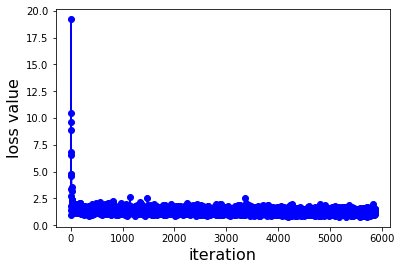

In [16]:
#run this if you want to train a new one
model.train(train, val, test, verbose = True)
model.save_model('./model-10-6-cnn')

In [12]:
#run this if you want to use my trained one
model = models.model_pretrained(path_dir = './model-9-24')

# Model validation

The following code is built in to the DeepPurpose `train` method, I've just pulled it out so I can grab the dataset that was set aside for validation during the data processing step. 

In [17]:
import torch
from torch.utils import data

params = {'batch_size': config['batch_size'],
    'shuffle': True,
    'num_workers': config['num_workers'],
    'drop_last': False}

validation_generator = data.DataLoader(utils.data_process_loader(val.index.values, val.Label.values, val, **config), **params)

The available performance metrics are ROC-AUC, PR-AUC, F1, cross-entropy loss, MSE, Pearson Correlation with p-value, and Concordance Index. I'm displaying the ROC-AUC here for comparison to the DeepIC50 paper. It's not at their level yet, but it's also not bad for a first try?

TODO: graph ROC curve, also why does test_ return "logits"

In [ ]:
model.binary = False
auc, auprc, f1, loss, logits = models.DBTA.test_(model, validation_generator, model.model, test=True)

In [19]:
print(auprc)

0.7055658796128017


In [40]:
#trying to get the ROC curve to actually plot...

#import matplotlib.pyplot as plt
#import sklearn
#from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score

#y_label = []
#roc_auc_file = os.path.join(model.result_folder, "roc-auc.jpg")
#plt.figure(0)
#sklearn.metrics.roc_curve(y_pred, y_label, roc_auc_file, model.drug_encoding)
#plt.figure(1)
#pr_auc_file = os.path.join(model.result_folder, "pr-auc.jpg")
#sklearn.metrics.prauc_curve(y_pred, y_label, pr_auc_file, model.drug_encoding)

# Model usage

To predict IC50, run data_process to create a dataset consisting of a single drug-target pair, and then run `predict`, which is just a wrapper on `test_`. The output is in pIC50. 

TODO: why do I need to include `y` as input?

In [28]:
X_drug = ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']
X_pred = utils.data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='no_split')
y_pred = model.predict(X_pred)
print('The predicted score is ' + str(y_pred))

Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
The predicted score is [7.395412921905518]
